<a href="https://colab.research.google.com/github/niral28/TransformersPuzzles/blob/main/TwoTowerRecommendationMovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

DATA_DIR='data'
# # ! wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/
! unzip archive.zip -d data/



Archive:  archive.zip
  inflating: data/README             
  inflating: data/u.data             
  inflating: data/u.item             
  inflating: data/u.user             
  inflating: data/ua.base            
  inflating: data/ua.test            


## Model Data & Featurization

In [4]:
def load_user_data(path:str)->pd.DataFrame:
  df_user = pd.read_csv(path, delimiter='|', header=None, names=['userId', 'age', 'gender', 'profession', 'zipcode'])

  # Define the bins and labels for age groups
  bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, float('inf')]
  labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75+']


  # Create a new column 'age_group' by binning the 'age' column
  df_user['age_group'] = pd.cut(df_user['age'], bins=bins, labels=labels, right=False)
  return df_user

In [5]:
df_user = load_user_data(os.path.join(DATA_DIR, 'u.user'))

le_age = LabelEncoder()
le_age.fit(df_user['age_group'])
le_job = LabelEncoder()
le_job.fit(df_user['profession'])
le_gender = LabelEncoder()
le_gender.fit(df_user['gender'])


def encodeFeatures(df_user, le_age, le_job, le_gender):
  df_user['age_group'] = le_age.transform(df_user['age_group'])
  df_user['profession'] = le_job.transform(df_user['profession'])
  df_user['gender'] = le_gender.transform(df_user['gender'])
  df_user.drop(columns=['age', 'zipcode'], inplace=True)

encodeFeatures(df_user, le_age, le_job, le_gender)
df_user.head()

,userId,gender,profession,age_group
0,1,1,19,2
1,2,0,13,9
2,3,1,20,2
3,4,1,19,2
4,5,0,13,4


In [6]:
def load_data(path:str)->pd.DataFrame:
  df_data = pd.read_csv(path, delimiter='\t', header=None, names=['userId', 'itemId', 'rating', 'timestamp'])
  df_data['like'] = df_data['rating'].apply(lambda x: 1 if x>=4 else 0)
  return df_data

In [7]:
import spacy
import pandas as pd
from typing import List, Dict
import re
from collections import Counter

class SpacyTitlePreprocessor:
    def __init__(self, model="en_core_web_sm"):
        # Load spaCy model
        self.nlp = spacy.load(model)

        # Custom patterns for movie-specific terms
        special_patterns = [
            {"label": "EDITION", "pattern": [{"LOWER": {"IN": ["director's", "directors", "director"]}, "OP": "?"},
                                          {"LOWER": "cut"}]},
            {"label": "EDITION", "pattern": [{"LOWER": "extended"}, {"LOWER": "edition", "OP": "?"}]},
            {"label": "EDITION", "pattern": [{"LOWER": "theatrical"}, {"LOWER": {"IN": ["cut", "version"]}, "OP": "?"}]},
            {"label": "YEAR", "pattern": [{"SHAPE": "dddd"}]}  # Match four digits
        ]

        # Add patterns to pipeline
        ruler = self.nlp.add_pipe("entity_ruler", before="ner")
        ruler.add_patterns(special_patterns)

    def preprocess_title(self, title: str) -> Dict:
        """Process a single title using spaCy."""
        # Process the title
        doc = self.nlp(title)

        # Extract base title (excluding year and edition)
        edition_spans = [ent.text for ent in doc.ents if ent.label_ == "EDITION"]
        year_spans = [ent.text for ent in doc.ents if ent.label_ == "YEAR"]

        # Remove entities from title
        cleaned_title = title
        for span in edition_spans + year_spans:
            cleaned_title = cleaned_title.replace(span, "")

        # Clean up remaining punctuation and extra spaces
        cleaned_title = re.sub(r'[^\w\s-]', ' ', cleaned_title)
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()

        # Extract lemmatized tokens (excluding stopwords and punctuation)
        tokens = [token.lemma_.lower() for token in doc
                 if not token.is_stop and not token.is_punct]

        return {
            'original_title': title,
            'cleaned_title': cleaned_title,
            'lemmatized_tokens': tokens,
            'edition': edition_spans[0] if edition_spans else None,
            'year': year_spans[0] if year_spans else None,
            'named_entities': [(ent.text, ent.label_) for ent in doc.ents],
            'pos_tags': [(token.text, token.pos_) for token in doc]
        }

    def process_titles(self, titles: List[str]) -> pd.DataFrame:
        """Process a list of titles and return as DataFrame."""
        processed_data = []

        for title in titles:
            title_data = self.preprocess_title(title)
            processed_data.append({
                'original_title': title_data['original_title'],
                'cleaned_title': title_data['cleaned_title'],
                'tokens': ' '.join(title_data['lemmatized_tokens']),
                'edition': title_data['edition'],
                'year': title_data['year'],
                'entities': title_data['named_entities'],
                'token_count': len(title_data['lemmatized_tokens'])
            })

        return pd.DataFrame(processed_data)

    def analyze_titles(self, titles: List[str]) -> Dict:
        """Generate analysis of the title dataset."""
        processed_df = self.process_titles(titles)

        # Collect all tokens
        all_tokens = ' '.join(processed_df['tokens']).split()
        token_freq = Counter(all_tokens)

        # Collect all named entities
        all_entities = [ent for entities in processed_df['entities']
                       for ent in entities]
        entity_types = Counter([ent[1] for ent in all_entities])

        return {
            'total_titles': len(titles),
            'unique_cleaned_titles': len(processed_df['cleaned_title'].unique()),
            'avg_token_count': processed_df['token_count'].mean(),
            'titles_with_year': processed_df['year'].notna().sum(),
            'titles_with_edition': processed_df['edition'].notna().sum(),
            'most_common_tokens': token_freq.most_common(10),
            'entity_type_distribution': dict(entity_types)
        }


In [8]:
def load_item(path:str)->pd.DataFrame:
  df_item = pd.read_csv(path, delimiter='|', header=None, encoding='latin-1')
  df_item.columns = [
    'itemId', 'title', 'releaseDate', 'videoReleaseDate', 'imdbUrl', 'unknown', 'action', 'adventure', 'animation',
    'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror', 'musical', 'mystery', 'romance',
    'sciFi', 'thriller', 'war', 'western'
  ]
  df_item.drop(columns=['releaseDate', 'videoReleaseDate', 'imdbUrl'], inplace=True)
  title_preprocessor = SpacyTitlePreprocessor()
  title_analysis = title_preprocessor.process_titles(df_item['title'])
  df_item['title'] = title_analysis['cleaned_title']
  return df_item

In [9]:
df_item = load_item(os.path.join(DATA_DIR, 'u.item'))
num_movies = df_item['itemId'].nunique()
# def generate_negative_samples(ratings_df, num_movies, neg_ratio=4):
#     """
#     Generates negative samples by randomly selecting movies a user hasn't rated.
#     """
#     all_movie_ids = set(range(num_movies))
#     negative_samples = []

#     for user_id, user_data in ratings_df.groupby("userId"):
#         positive_movies = set(user_data["itemId"].values)
#         negative_movies = list(all_movie_ids - positive_movies)
#         sampled_negatives = np.random.choice(negative_movies, size=min(len(positive_movies) * neg_ratio, len(negative_movies)), replace=False)

#         for neg_movie in sampled_negatives:
#             negative_samples.append([user_id, neg_movie, 0])  # '0' for negative label

#     negative_df = pd.DataFrame(negative_samples, columns=["userId", "itemId", "like"])
#     return pd.concat([ratings_df[["userId", "itemId", "like"]], negative_df]).sample(frac=1).reset_index(drop=True)


df_data = load_data(os.path.join(DATA_DIR, 'u.data'))
df_data_train = load_data(os.path.join(DATA_DIR, 'ua.base'))
df_data_test = load_data(os.path.join(DATA_DIR, 'ua.test'))

In [10]:
def get_mergedDF(df_data, df_user, df_item):
  merged_df = df_data.merge(df_user, on='userId').merge(df_item, on='itemId')
  return merged_df

merged_df = get_mergedDF(df_data, df_user, df_item)
merged_df_train = get_mergedDF(df_data_train, df_user, df_item)
merged_df_test = get_mergedDF(df_data_test, df_user, df_item)
merged_df.head()

,userId,itemId,rating,timestamp,like,gender,profession,age_group,title,unknown,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,196,242,3,881250949,0,1,20,7,Kolya,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,0,0,6,5,L A Confidential,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,0,1,20,3,Heavyweights,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,0,1,19,3,Legends of the Fall,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,0,1,3,7,Jackie Brown,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
num_genres = len(df_item.drop(columns=['itemId', 'title']).iloc[0].values)
num_age_groups = df_user['age_group'].nunique()+1
num_professions = df_user['profession'].nunique()+1
num_users = df_user['userId'].max()+1
num_movies = df_item['itemId'].nunique()+1

In [12]:
from transformers import DistilBertTokenizer
class MovieDatasetWithFeatures(torch.utils.data.Dataset):
    def __init__(self, ratings_df, device):
        """
        ratings_df: DataFrame containing columns ['userId', 'itemId', 'like', 'age_group', 'gender', 'profession', genre columns]
        device: Device to load tensors on (e.g., 'cuda' or 'cpu')
        """
        self.device = device
        self.ratings_df = ratings_df
        self.genre_df = self.ratings_df.drop(columns=["userId", "itemId", "title", "rating", "timestamp", "gender", "profession", "age_group", "like"], errors='ignore')
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.encoded_titles = self.tokenizer(
            ratings_df['title'].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors=None,
        )

    def __len__(self):
        return len(self.ratings_df)

    def __getitem__(self, idx):
        row = self.ratings_df.iloc[idx]
        user_tensor = torch.tensor(row['userId'], dtype=torch.long).to(self.device)
        age_tensor = torch.tensor(row['age_group'], dtype=torch.long).to(self.device)
        gender_tensor = torch.tensor(row['gender'], dtype=torch.long).to(self.device)
        profession_tensor = torch.tensor(row['profession'], dtype=torch.long).to(self.device)
        movie_tensor = torch.tensor(row['itemId'], dtype=torch.long).to(self.device)
        title_ids = torch.tensor(self.encoded_titles['input_ids'][idx], dtype=torch.long).to(self.device)
        title_mask = torch.tensor(self.encoded_titles['attention_mask'][idx], dtype=torch.long).to(self.device)
        genre_tensor = torch.tensor(self.genre_df.iloc[idx].values, dtype=torch.float).to(self.device)
        like_tensor = torch.tensor(row['like'], dtype=torch.long).to(self.device)

        return user_tensor, age_tensor, gender_tensor, profession_tensor, movie_tensor, title_ids, title_mask, genre_tensor, like_tensor


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
dataset = MovieDatasetWithFeatures(merged_df_train, device)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Model Training

In [15]:
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from transformers import DistilBertModel

def info_nce_loss(similarity_matrix, temperature=0.07):
    # Positive pairs are on diagonal
    batch_size = similarity_matrix.size(0)
    labels = torch.arange(batch_size, device=similarity_matrix.device)

    # Scale similarities
    similarity_matrix = similarity_matrix / temperature

    # InfoNCE loss: -log(exp(pos_score) / sum(exp(all_scores)))
    loss = F.cross_entropy(similarity_matrix, labels)
    return loss


class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

class MovieTwoTowerModel(nn.Module):
  def __init__(self, num_users, num_movies, num_age_groups, num_professions, num_genres, embedding_dim):
    super(MovieTwoTowerModel, self).__init__()
    self.num_users = num_users
    self.num_movies = num_movies
    self.num_genres = num_genres
    self.num_age_groups = num_age_groups
    self.num_professions = num_professions
    self.embedding_dim = embedding_dim

    self.user_embedding = nn.Embedding(num_users, embedding_dim)
    self.age_embedding = nn.Embedding(num_age_groups, 4)
    self.profession_embedding = nn.Embedding(num_professions, 4)
    self.gender_embedding = nn.Embedding(2, 2)

    self.user_fc = nn.Sequential(
        nn.Linear(embedding_dim+4+4+2, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),

    )

    self.genre_fc = nn.Linear(num_genres, 16)
    self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
    self.movie_title_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
    # Freeze emedding layers
    for param in self.movie_title_encoder.parameters():
        param.requires_grad = False
    self.movie_title_projection = nn.Linear(768, 256)
    self.movie_fc = nn.Sequential(

        nn.Linear(embedding_dim+256+16, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),

        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),

        nn.Linear(256, 128),
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
    self.early_stopper = EarlyStopping()
    self.scheduler = ReduceLROnPlateau(self.optimizer, 'min')
    self.temperature = 0.07
    self.train_loss = []
    self.val_loss = []

  def get_early_stopper(self):
    return self.early_stopper

  def get_metrics(self):
    return self.train_loss, self.val_loss

  def forward(self, user_input, age_input, gender_input, profession_input, movie_input, title_ids, title_mask, genre_feats, like=None):
    # User Tower
    user_embedding = self.user_embedding(user_input)
    age_embedding = self.age_embedding(age_input)
    profession_embedding = self.profession_embedding(profession_input)
    gender_embedding = self.gender_embedding(gender_input)
    user_feats = torch.cat([user_embedding, age_embedding, profession_embedding, gender_embedding], dim=1)
    # print(user_feats.shape)
    user_feats = self.user_fc(user_feats)
    # print("user", user_feats.shape)

    # Movie Tower
    movie_embedding = self.movie_embedding(movie_input)
    genre_embedding = self.genre_fc(genre_feats)
    title_embeddings = self.movie_title_encoder(
        title_ids,
        attention_mask=title_mask
    ).last_hidden_state[:, 0, :]
    title_embeddings = self.movie_title_projection(title_embeddings.float())
    movie_feats = torch.cat([movie_embedding, title_embeddings, genre_embedding], dim=1)
    # print(movie_feats.shape)
    movie_feats = self.movie_fc(movie_feats)
    # print("movie", movie_feats.shape)
    user_feats = F.normalize(user_feats, p=2, dim=1)
    movie_feats = F.normalize(movie_feats, p=2, dim=1)
    # Compute Similarity Mtarix
    similarity_matrix = torch.matmul(user_feats, movie_feats.transpose(0, 1))
    if like is not None:
      loss = info_nce_loss(similarity_matrix, temperature=self.temperature)
      return loss, similarity_matrix, user_feats, movie_feats
    else:
      return similarity_matrix, user_feats, movie_feats

  def user_tower(self, user_input, age_input, gender_input, profession_input):
    user_embedding = self.user_embedding(user_input)
    age_embedding = self.age_embedding(age_input)
    profession_embedding = self.profession_embedding(profession_input)
    gender_embedding = self.gender_embedding(gender_input)
    user_feats = torch.cat([user_embedding, age_embedding, profession_embedding, gender_embedding], dim=1)
    user_feats = self.user_fc(user_feats)
    user_feats = F.normalize(user_feats, p=2, dim=1)
    return user_feats

  def movie_tower(self, movie_input, title_ids, title_mask, genre_input):
    movie_embedding = self.movie_embedding(movie_input)
    genre_embedding = self.genre_fc(genre_input)
    title_embeddings = self.movie_title_encoder(
        title_ids,
        attention_mask=title_mask
    ).last_hidden_state[:, 0, :]
    title_embeddings = self.movie_title_projection(title_embeddings.float())
    movie_feats = torch.cat([movie_embedding, title_embeddings, genre_embedding], dim=1)
    movie_feats = self.movie_fc(movie_feats)
    movie_feats = F.normalize(movie_feats, p=2, dim=1)
    return movie_feats

  def fit(self, epochs, train_dataloader, val_dataloader):
      early_stopper = EarlyStopping(patience=5, delta=10)
      for epoch in range(epochs):
          self.train()
          epoch_loss = 0.0
          batch_count = 0
          for batch in train_dataloader:
              user_input, age_input, gender_input, profession_input, movie_input, title_ids, title_mask, genre_feats, like = batch
              batch_count+=1
              print(f'starting batch {batch_count}')
              loss, _ , _ , _ = self(user_input, age_input, gender_input, profession_input, movie_input, title_ids, title_mask, genre_feats, like)
              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()
              epoch_loss += loss.item()
              print(f'finished batch {batch_count}')
          avg_train_loss = epoch_loss / len(train_dataloader)
          print(f"train step {epoch}: train loss {avg_train_loss:.4f}")
          self.train_loss.append(avg_train_loss)
          self.eval()
          val_loss = 0.0
          for batch in val_dataloader:
              user_input, age_input, gender_input, profession_input, movie_input, title_ids, title_mask, genre_feats, like = batch
              loss, _ , _ , _ = self(user_input, age_input, gender_input, profession_input, movie_input, title_ids, title_mask, genre_feats, like)
              val_loss += loss.item()
          avg_val_loss = val_loss / len(val_dataloader)
          print(f"val step {epoch}: val loss {avg_val_loss:.4f}")
          self.val_loss.append(avg_val_loss)
          self.scheduler.step(avg_val_loss)
          self.train()
          self.early_stopper(avg_val_loss, model)
          if self.early_stopper.early_stop:
              print("Early stopping")
              break


In [16]:
model = MovieTwoTowerModel(num_users, num_movies, num_age_groups, num_professions, num_genres, 64).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [17]:
num_epochs=20
model.fit(num_epochs, train_dataloader, val_dataloader)
model.get_early_stopper().load_best_model(model)

starting batch 1
finished batch 1
starting batch 2
finished batch 2
starting batch 3
finished batch 3
starting batch 4
finished batch 4
starting batch 5
finished batch 5
starting batch 6
finished batch 6
starting batch 7
finished batch 7
starting batch 8
finished batch 8
starting batch 9
finished batch 9
starting batch 10
finished batch 10
starting batch 11
finished batch 11
starting batch 12
finished batch 12
starting batch 13
finished batch 13
starting batch 14
finished batch 14
starting batch 15
finished batch 15
starting batch 16
finished batch 16
starting batch 17
finished batch 17
starting batch 18
finished batch 18
starting batch 19
finished batch 19
starting batch 20
finished batch 20
starting batch 21
finished batch 21
starting batch 22
finished batch 22
starting batch 23
finished batch 23
starting batch 24
finished batch 24
starting batch 25
finished batch 25
starting batch 26
finished batch 26
starting batch 27
finished batch 27
starting batch 28
finished batch 28
starting b

In [18]:
model.early_stopper.load_best_model(model)

In [19]:
merged_df.head()

,userId,itemId,rating,timestamp,like,gender,profession,age_group,title,unknown,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,196,242,3,881250949,0,1,20,7,Kolya,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,0,0,6,5,L A Confidential,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,0,1,20,3,Heavyweights,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,0,1,19,3,Legends of the Fall,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,0,1,3,7,Jackie Brown,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_data_train.head()

,userId,itemId,rating,timestamp,like
0,1,1,5,874965758,1
1,1,2,3,876893171,0
2,1,3,4,878542960,1
3,1,4,3,876893119,0
4,1,5,3,889751712,0


In [21]:
load_data(os.path.join(DATA_DIR, 'u.data')).groupby('like').count()

,userId,itemId,rating,timestamp
like,,,,
0,44625,44625,44625,44625
1,55375,55375,55375,55375


In [22]:
grouped_data = load_data(os.path.join(DATA_DIR, 'u.data')).groupby(['userId', 'like']).count()
grouped_data['itemId']

userId  like
1       0       109
        1       163
2       0        22
        1        40
3       0        39
               ... 
941     1        18
942     0        13
        1        66
943     0        72
        1        96
Name: itemId, Length: 1883, dtype: int64

In [23]:
ratio_grouped_data = grouped_data['itemId']/load_data(os.path.join(DATA_DIR, 'u.data')).groupby(['userId']).count()['itemId']
ratio_grouped_data

userId  like
1       0       0.400735
        1       0.599265
2       0       0.354839
        1       0.645161
3       0       0.722222
                  ...   
941     1       0.818182
942     0       0.164557
        1       0.835443
943     0       0.428571
        1       0.571429
Name: itemId, Length: 1883, dtype: float64

In [24]:
np.mean(ratio_grouped_data[ratio_grouped_data.index.get_level_values(1) == 1])

0.5788217321525728

Text(0, 0.5, 'Number of Users')

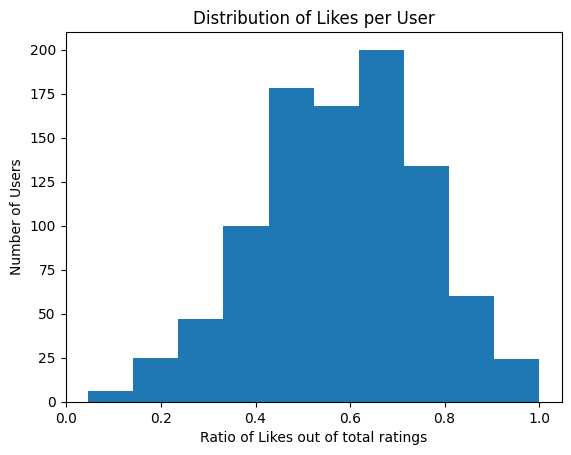

In [25]:
plt.hist(ratio_grouped_data[ratio_grouped_data.index.get_level_values(1) == 1])
plt.title('Distribution of Likes per User')
plt.xlabel('Ratio of Likes out of total ratings')
plt.ylabel('Number of Users')

In [26]:
np.mean(ratio_grouped_data[ratio_grouped_data.index.get_level_values(1) == 0])

0.42268855293546914

Text(0, 0.5, 'Number of Users')

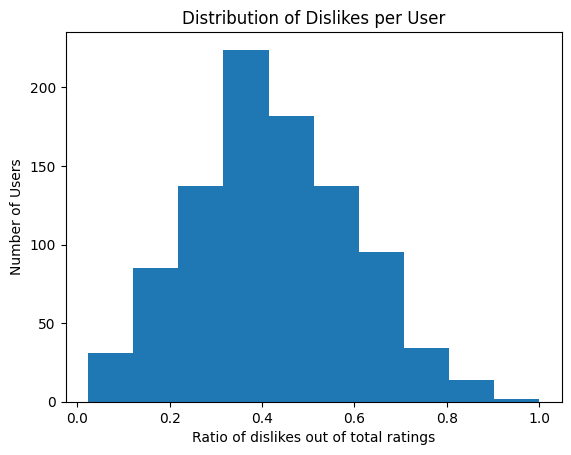

In [27]:
plt.hist(ratio_grouped_data[ratio_grouped_data.index.get_level_values(1) == 0])
plt.title('Distribution of Dislikes per User')
plt.xlabel('Ratio of dislikes out of total ratings')
plt.ylabel('Number of Users')

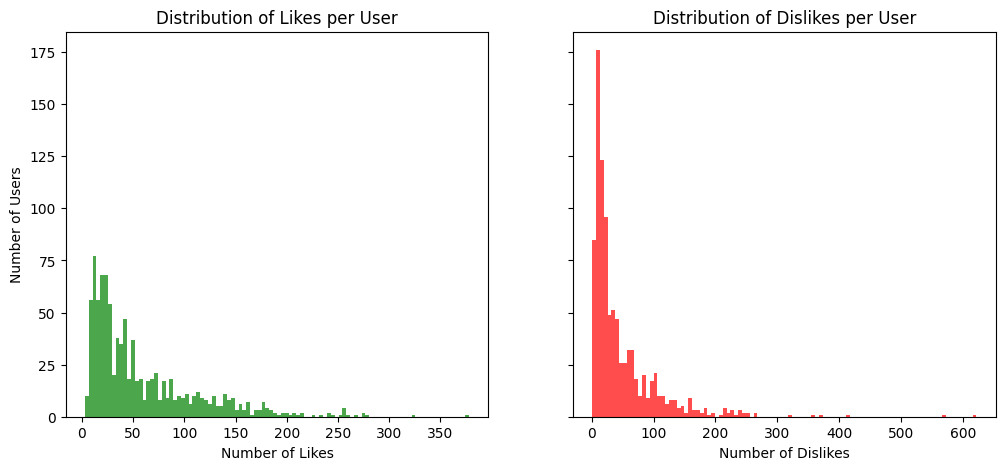

In [28]:
grouped_data = load_data(os.path.join(DATA_DIR, 'u.data')).groupby(['userId', 'like']).count()

# Create separate DataFrames for likes and dislikes
likes_df = grouped_data.loc[pd.IndexSlice[:, 1], :].reset_index(level=1, drop=True)
dislikes_df = grouped_data.loc[pd.IndexSlice[:, 0], :].reset_index(level=1, drop=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot likes histogram
axes[0].hist(likes_df['itemId'], bins=100, color='green', alpha=0.7)
axes[0].set_title('Distribution of Likes per User')
axes[0].set_xlabel('Number of Likes')
axes[0].set_ylabel('Number of Users')

# Plot dislikes histogram
axes[1].hist(dislikes_df['itemId'], bins=100, color='red', alpha=0.7)
axes[1].set_title('Distribution of Dislikes per User')
axes[1].set_xlabel('Number of Dislikes')

# Display the plot
plt.show()

In [29]:
load_data(os.path.join(DATA_DIR, 'ua.base')).groupby('like').count()

,userId,itemId,rating,timestamp
like,,,,
0,40664,40664,40664,40664
1,49906,49906,49906,49906


In [30]:
load_data(os.path.join(DATA_DIR, 'ua.test')).groupby('like').count()

,userId,itemId,rating,timestamp
like,,,,
0,3961,3961,3961,3961
1,5469,5469,5469,5469


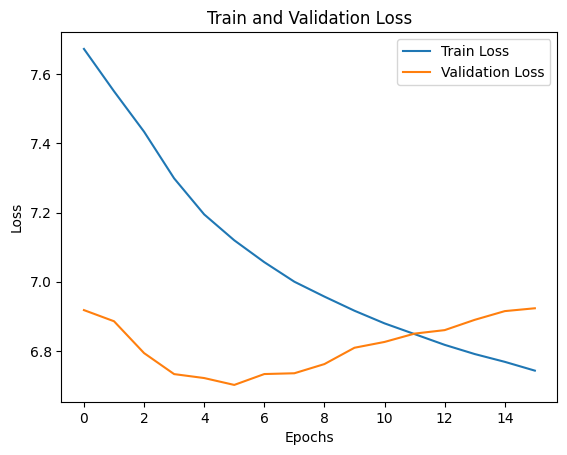

In [31]:
import matplotlib.pyplot as plt

train_losses, val_losses= model.get_metrics()
epochs = range(len(train_losses))

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


In [49]:
test_dataset = MovieDatasetWithFeatures(merged_df_test, device)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)
similarity_matrices = []
model.eval()
test_loss = []
for batch in test_dataloader:
    user_input, age_input, gender_input, profession_input, movie_input, title_ids, title_mask, genre_feats, like = batch
    loss, similarity_matrix, user_feats, movie_feats = model(user_input, age_input, gender_input, profession_input, movie_input, title_ids, title_mask, genre_feats, like)
    similarity_matrices.append(similarity_matrix)
    print(f"test loss {loss:.4f}")
    test_loss.append(loss.item())

print(f"overall average test loss {np.mean(test_loss):.4f}")

test loss 6.1676
test loss 6.1564
test loss 6.1414
test loss 6.1002
test loss 6.1390
test loss 6.1353
test loss 6.1133
test loss 6.1075
test loss 6.1265
test loss 6.1250
test loss 6.2120
test loss 5.9907
test loss 6.0687
test loss 6.1048
test loss 6.1670
test loss 6.1213
test loss 5.9977
test loss 6.2646
test loss 5.3962
overall average test loss 6.0861


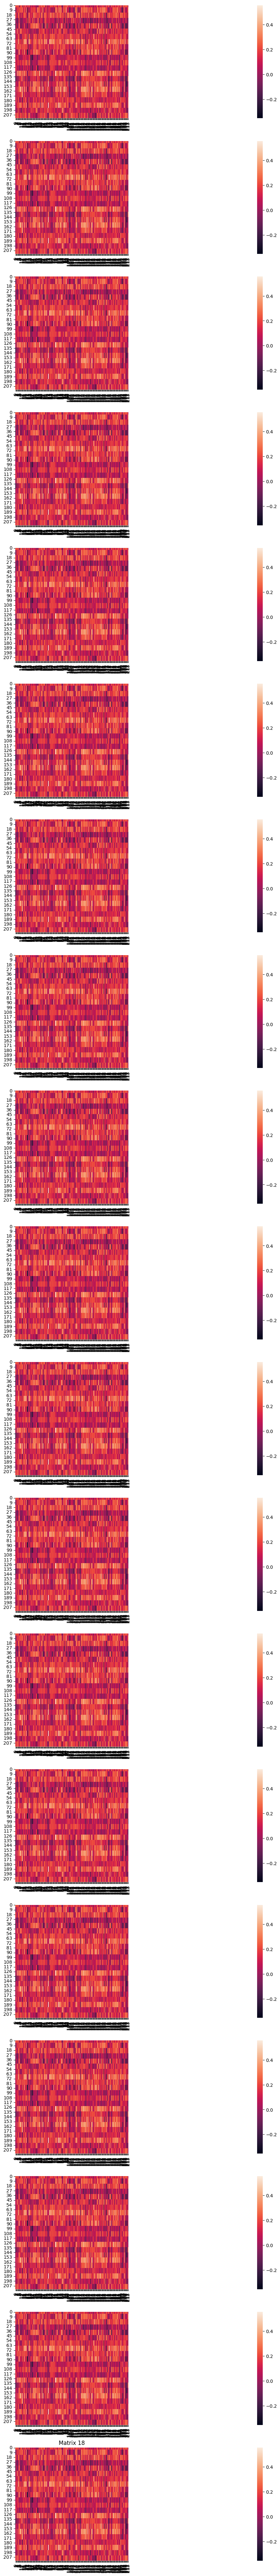

In [50]:
fig, ax = plt.subplots(nrows=len(similarity_matrices), figsize=(100, 100))
for i, matrix in enumerate(similarity_matrices):
  plt.title('Matrix {}'.format(i))
  sns.heatmap(similarity_matrix.detach().cpu().numpy(), square=True, ax=ax[i])

In [33]:
df_user.head()

,userId,gender,profession,age_group
0,1,1,19,2
1,2,0,13,9
2,3,1,20,2
3,4,1,19,2
4,5,0,13,4


In [34]:
merged_df[merged_df['userId']==27].groupby('like').count()

,userId,itemId,rating,timestamp,gender,profession,age_group,title,unknown,action,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
like,,,,,,,,,,,,,,,,,,,,,
0,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

In [39]:
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_titles = tokenizer(
          df_item['title'].tolist(),
          padding=True,
          truncation=True,
          max_length=128,
          return_tensors=None,
      )
title_ids = torch.tensor(encoded_titles['input_ids'], dtype=torch.long).to(device)
title_mask = torch.tensor(encoded_titles['attention_mask'], dtype=torch.long).to(device)
movie_embeddings = model.movie_tower(torch.tensor(df_item['itemId'].values, dtype=torch.long).to(device), title_ids, title_mask, torch.tensor(df_item.drop(columns=['itemId', 'title']).values, dtype=torch.float).to(device))
embs = tsne.fit_transform(movie_embeddings.detach().cpu().numpy())
df_item['x'] = embs[:, 0]
df_item['y'] = embs[:, 1]



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [79]:
encoded_titles['input_ids'][2]

[101, 2176, 4734, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [81]:
encoded_titles['attention_mask'][2]

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# df_item2 = pd.read_csv(os.path.join(DATA_DIR, 'u.item'), delimiter='|', header=None, encoding='latin-1')
# df_item2.columns = [
#     'itemId', 'title', 'releaseDate', 'videoReleaseDate', 'imdbUrl', 'unknown', 'action', 'adventure', 'animation',
#     'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror', 'musical', 'mystery', 'romance',
#     'sciFi', 'thriller', 'war', 'western'
# ]
# df_item2.drop(columns=['unknown', 'action', 'adventure', 'animation',
#     'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror', 'musical', 'mystery', 'romance',
#     'sciFi', 'thriller', 'war', 'western'], inplace=True)

In [40]:
full_df_item = df_item

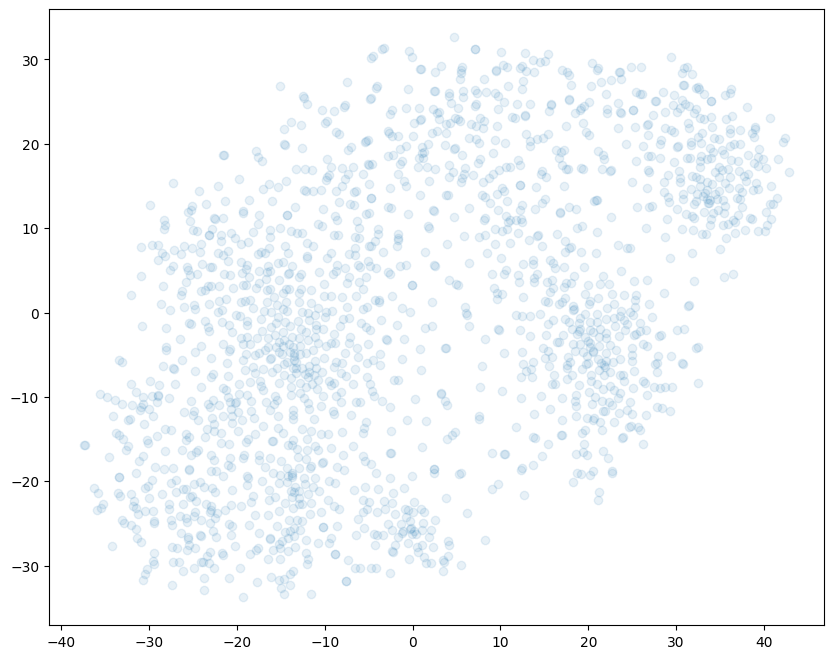

In [41]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(full_df_item.x, full_df_item.y, alpha=.1);

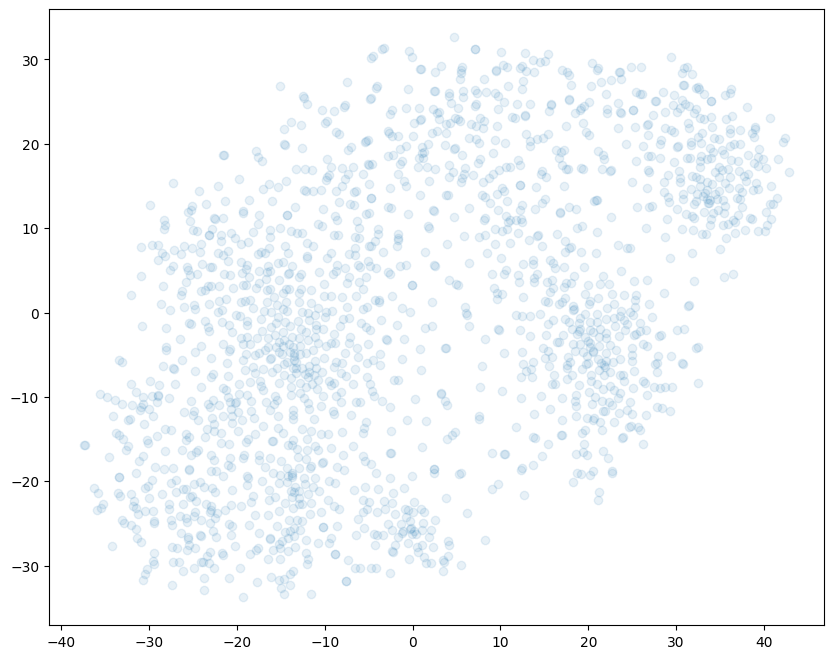

In [42]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(full_df_item.x, full_df_item.y, alpha=.1);

In [43]:
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(df, n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = df[df.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(df, sample.index)

def plot_by_title_pattern(df, pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.title.str.contains(pattern)]
    return plot_with_annotations(df, match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(df, label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')

    if text:
        # TODO: Add abbreviated title column
        titles = df.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts,
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(df, x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(df, title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    print(match)
    row = match.iloc[0]
    return plot_region(df, row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

<Axes: >

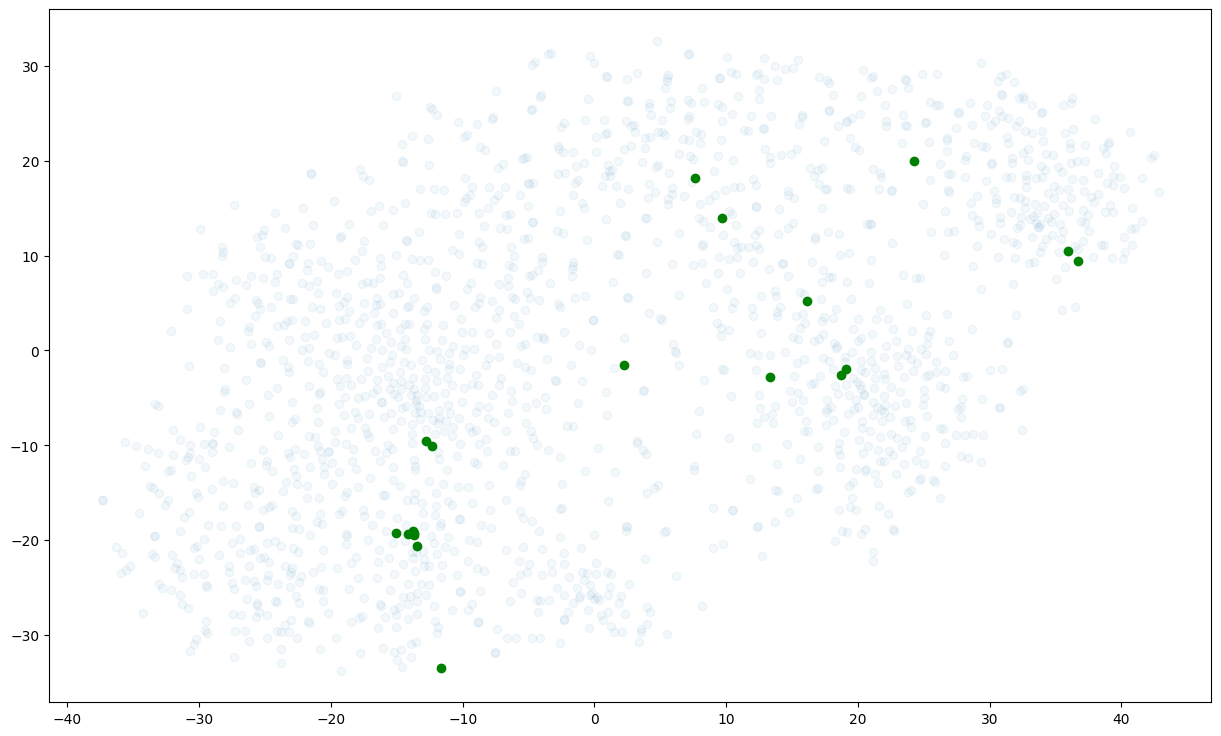

In [44]:
plot_by_title_pattern(full_df_item, 'Star', figsize=(15, 9), bg_alpha=.05, text=False)

In [45]:

!pip install fuzzywuzzy
from fuzzywuzzy import process


def movie_finder(title, df):
  all_titles = df['title'].tolist()
  closest_match = process.extractOne(title, all_titles)
  return closest_match

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [46]:
full_df_item[full_df_item.title == movie_finder('Star', full_df_item)[0]]

,itemId,title,unknown,action,adventure,animation,children,comedy,crime,documentary,...,horror,musical,mystery,romance,sciFi,thriller,war,western,x,y
49,50,Star Wars,0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,1,0,19.054546,-1.917323


In [47]:
movie_finder('Star', full_df_item)

('Star Wars', 90)

James and the Giant Peach
     itemId                      title  unknown  action  adventure  animation  \
472     473  James and the Giant Peach        0       0          0          1   

     children  comedy  crime  documentary  ...  horror  musical  mystery  \
472         1       0      0            0  ...       0        1        0   

     romance  sciFi  thriller  war  western          x         y  
472        0      0         0    0        0  15.837938 -5.267747  

[1 rows x 23 columns]


<Axes: >

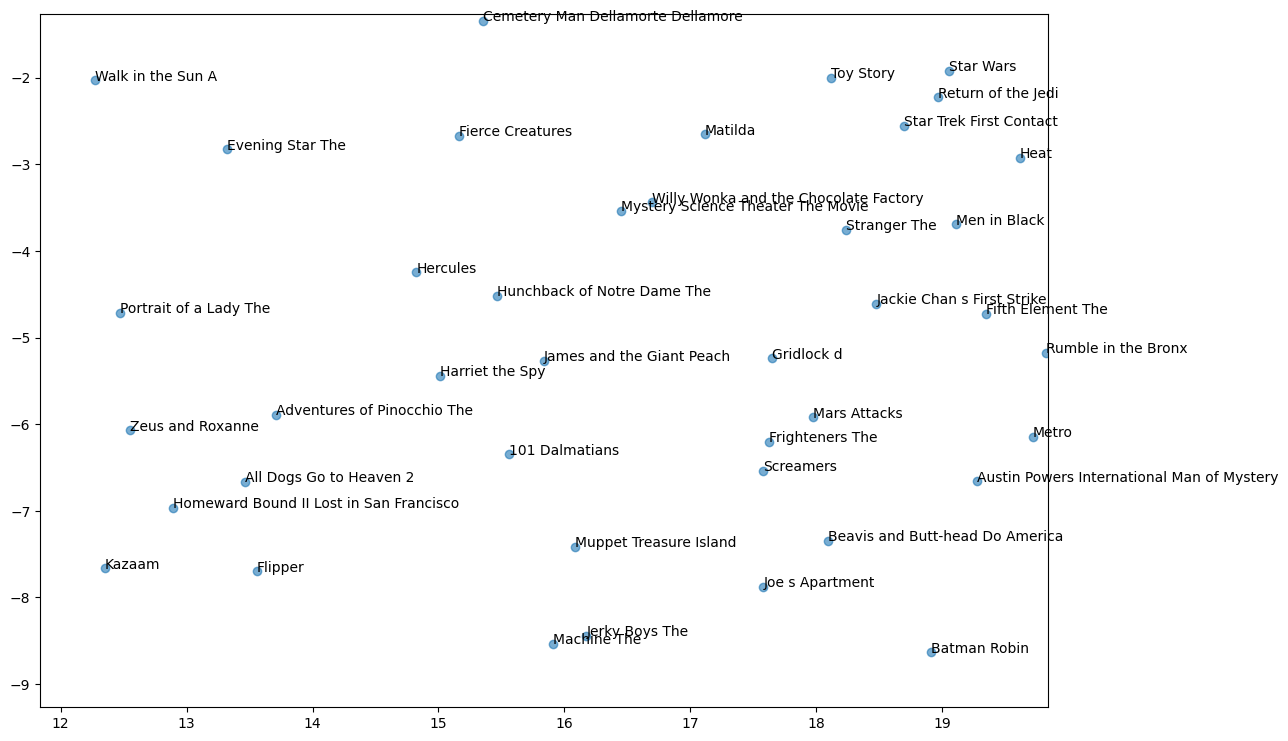

In [48]:
title = movie_finder('James Bond', full_df_item)[0]
print(title)
plot_region_around(full_df_item, title, 4)

Text(0.5, 1.0, 'Comedy Clusters')

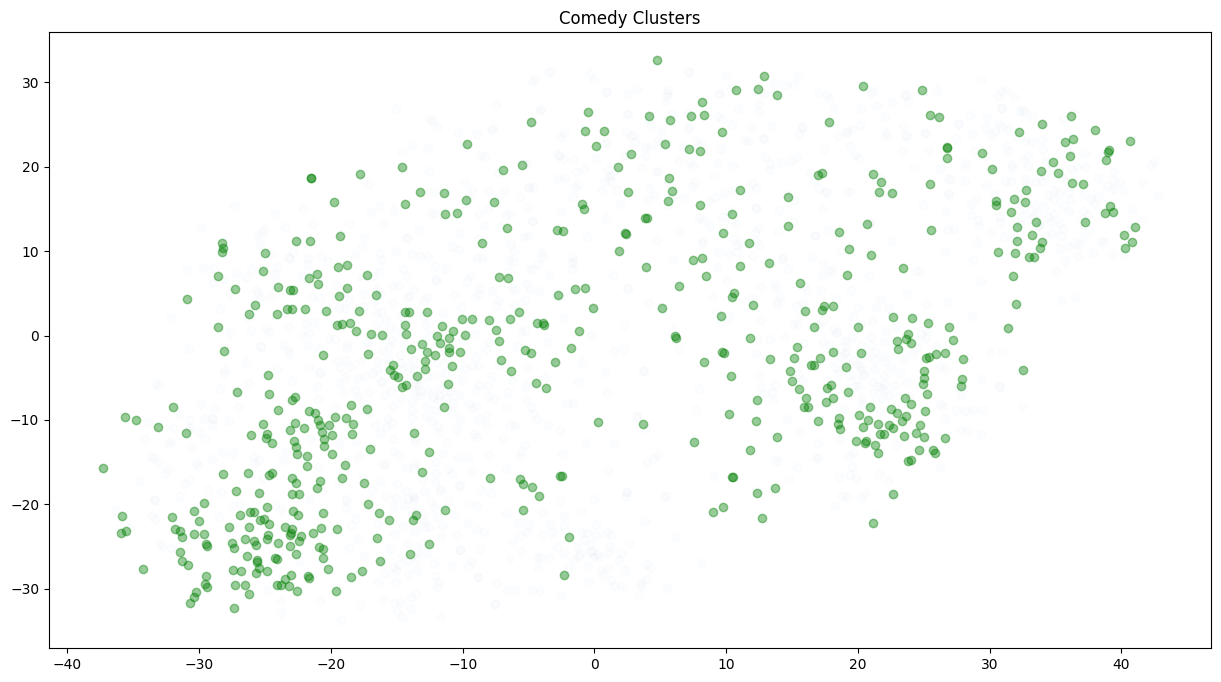

In [49]:
docs = full_df_item[ (full_df_item.comedy == 1) ]
plot_with_annotations(full_df_item, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('Comedy Clusters')

Text(0.5, 1.0, 'Children Clusters')

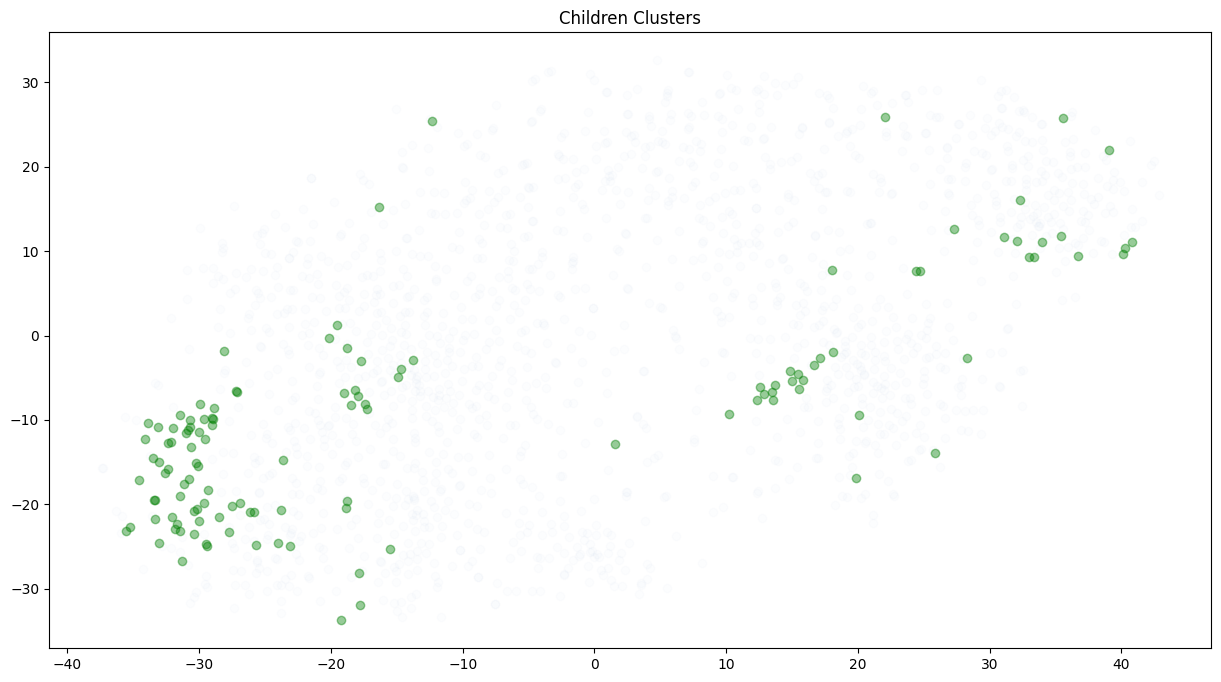

In [50]:
docs = full_df_item[ (full_df_item.children == 1) ]
plot_with_annotations(full_df_item, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('Children Clusters')

Text(0.5, 1.0, 'Romance Clusters')

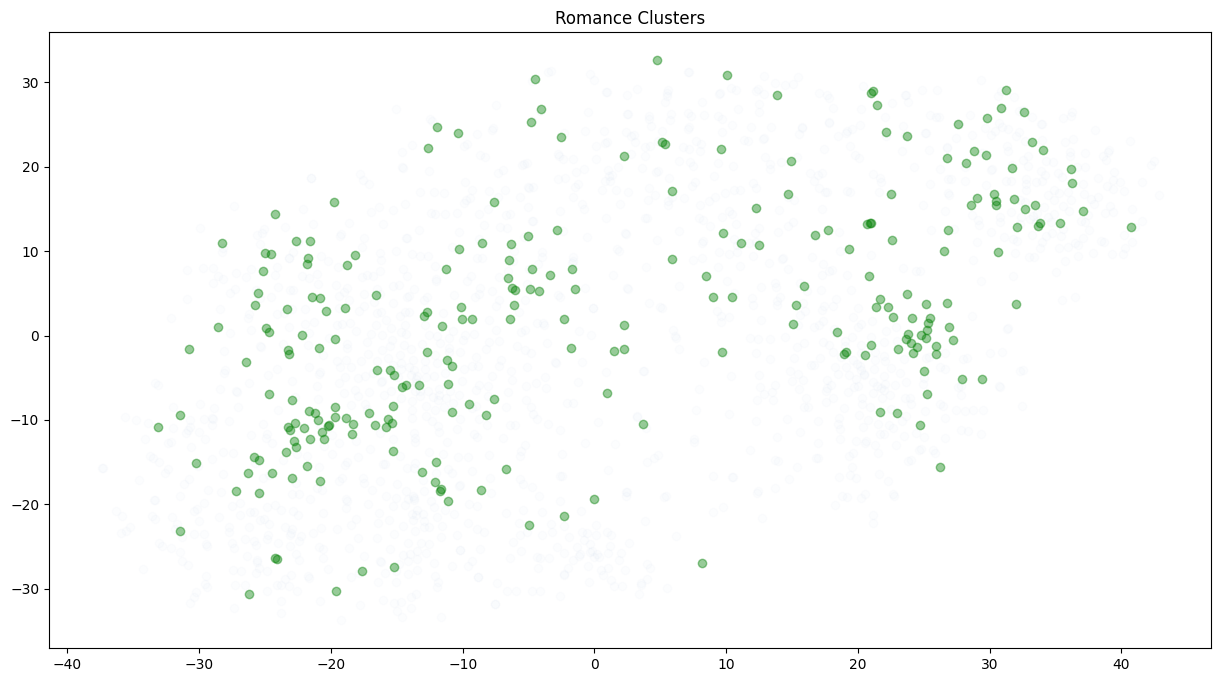

In [51]:
docs = full_df_item[ (full_df_item.romance == 1) ]
plot_with_annotations(full_df_item, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('Romance Clusters')

Text(0.5, 1.0, 'SciFi Clusters')

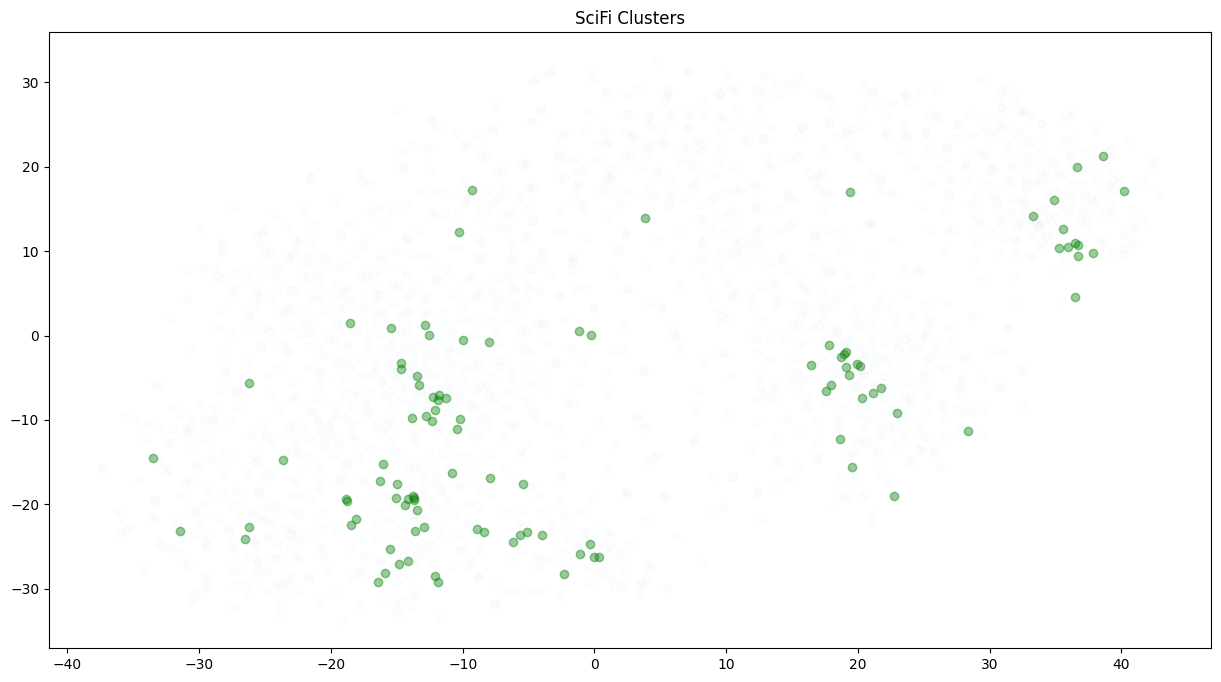

In [52]:
docs = full_df_item[ (full_df_item.sciFi == 1) ]
plot_with_annotations(full_df_item, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('SciFi Clusters')

In [53]:
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")
user_embeddings = model.user_tower(torch.tensor(df_user['userId'], dtype=torch.long).to(device),
                                     torch.tensor(df_user['age_group'], dtype=torch.long).to(device),
                                     torch.tensor(df_user['gender'], dtype=torch.long).to(device),
                                     torch.tensor(df_user['profession'], dtype=torch.long).to(device))



In [54]:
embs = tsne.fit_transform(user_embeddings.detach().cpu().numpy())
df_user['x'] = embs[:, 0]
df_user['y'] = embs[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


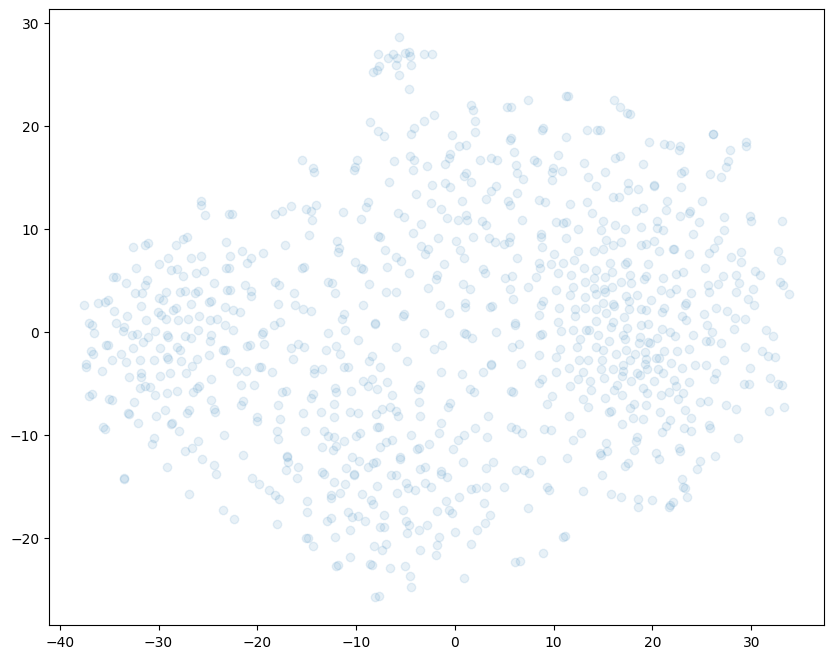

In [55]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df_user.x, df_user.y, alpha=.1)

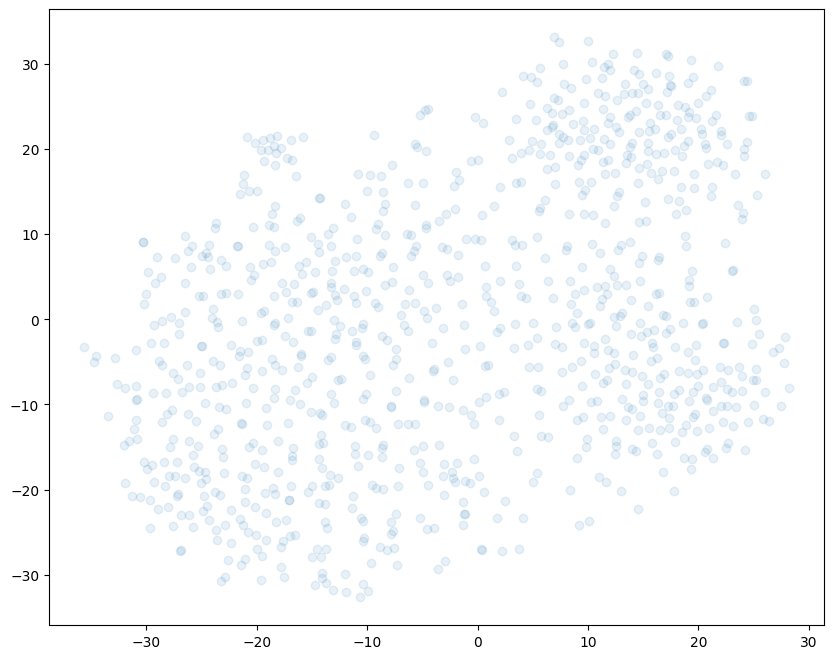

In [ ]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df_user.x, df_user.y, alpha=.1)

Text(0.5, 1.0, 'Age Group 20-25')

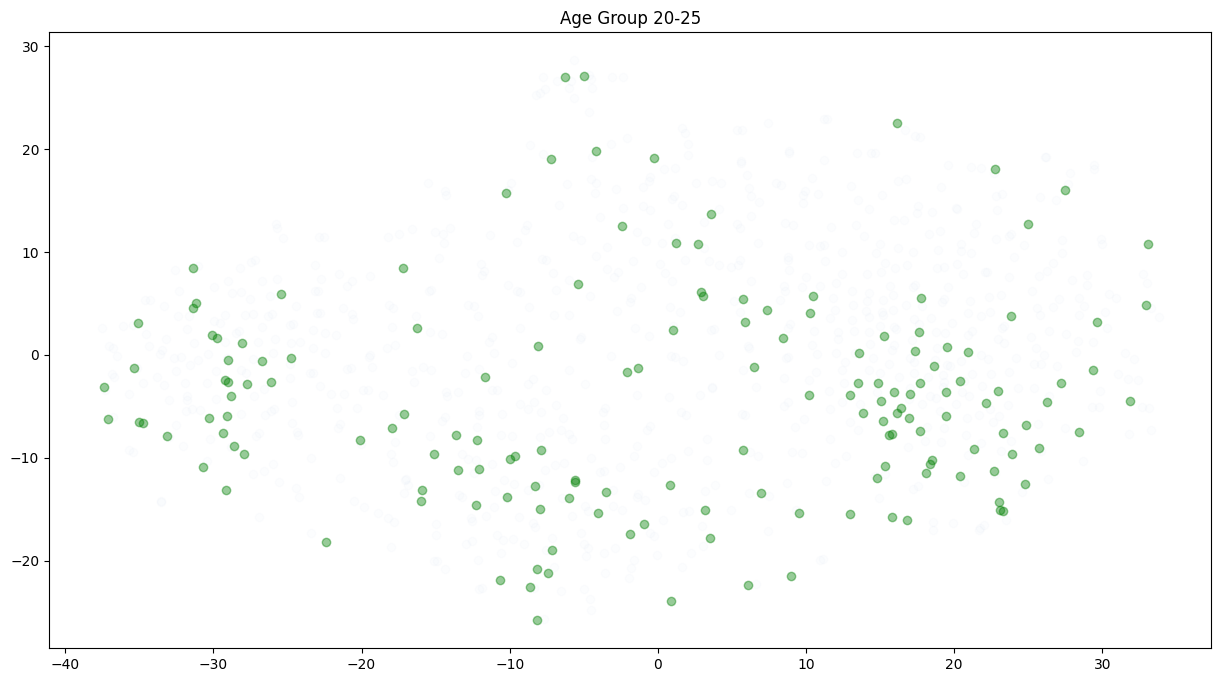

In [56]:
docs = df_user[ (df_user.age_group == 2) ]
plot_with_annotations(df_user, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('Age Group 20-25')

In [57]:
le_gender.inverse_transform([0])

array(['F'], dtype=object)

In [ ]:
df_user

,userId,gender,profession,age_group,x,y
0,1,1,19,2,-20.701006,-5.319801
1,2,0,13,9,6.994538,-2.760030
2,3,1,20,2,40.437958,-2.116040
3,4,1,19,2,40.856258,4.038387
4,5,0,13,4,-20.698507,1.776551
...,...,...,...,...,...,...
938,939,0,18,3,2.943630,-12.191275
939,940,1,0,4,1.020343,11.913427
940,941,1,18,2,10.654618,-12.651905
941,942,0,10,7,-8.221417,12.491845


In [ ]:
df_data_train[df_data_train['userId']==13]

,userId,itemId,rating,timestamp,like
1578,13,1,3,882140487,0
1579,13,2,3,882397650,0
1580,13,4,5,882141306,1
1581,13,5,1,882396869,0
1582,13,7,2,882396790,0
...,...,...,...,...,...
2199,13,914,2,892870589,0
2200,13,915,5,892015023,1
2201,13,916,4,892870589,1
2202,13,917,4,892015104,1


In [67]:
title_ids = torch.tensor(encoded_titles['input_ids'][915], dtype=torch.long).to(device)
title_mask = torch.tensor(encoded_titles['attention_mask'][915], dtype=torch.long).to(device)

In [69]:
curr_df = df_user[df_user['userId']==13]



user_embeddings = model.user_tower(torch.tensor(curr_df['userId'].values, dtype=torch.long).to(device),
                                     torch.tensor(curr_df['age_group'].values, dtype=torch.long).to(device),
                                     torch.tensor(curr_df['gender'].values, dtype=torch.long).to(device),
                                     torch.tensor(curr_df['profession'].values, dtype=torch.long).to(device))
user_embeddings = user_embeddings.squeeze(0).detach().cpu().numpy()

In [2]:
curr_movie_df = df_item[df_item['itemId']==916]
title_ids = torch.tensor(encoded_titles['input_ids'][915], dtype=torch.long).to(device)
title_ids = torch.unsqueeze(title_ids)
title_mask = torch.tensor(encoded_titles['attention_mask'][915], dtype=torch.long).to(device)
title_mask = torch.unsqueeze(title_mask)
print(model.movie_title_encoder(title_ids, attention_mask=title_mask))

# movie_embeddings = model.movie_tower(torch.tensor(curr_movie_df['itemId'].values, dtype=torch.long).to(device),
#                                      title_ids,
#                                      title_mask,
#                                      torch.tensor(curr_movie_df.drop(columns=['itemId', 'title', 'x', 'y']).values, dtype=torch.float).to(device))


NameError: name 'df_item' is not defined

In [85]:
len(encoded_titles['input_ids'])

1682

In [72]:
title_mask.shape

torch.Size([22])

In [ ]:
movie_embeddings = movie_embeddings.squeeze(0).detach().cpu().numpy()
print(np.dot(user_embeddings, movie_embeddings))

0.14858645


,itemId,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,...,horror,musical,mystery,romance,sciFi,thriller,war,western,x,y
19,20,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,28.109411,-22.423807
